# Ejemplo de transferencia de estilo
**Autor**: Eduardo Escobar

Este cuaderno implementa el algoritmo de trasnferencia de estilo planteado en el artículo **A Neural Algorithm of Artistic Style** (disponible en https://arxiv.org/abs/1508.06576).

La implementación es adaptada del ejemplo del sitio web de Keras: (https://keras.io/examples/generative/neural_style_transfer/). 


---
## 1. Definir todo lo necesario para realizar el entrenamiento

### 1.1 Importar librerías y paquetes necesarios

In [1]:
import cv2
import numpy as np
import tensorflow as tf
from IPython.display import Image, display
from tensorflow import keras
from tensorflow.keras.applications import vgg19

### 1.2 Definir parámetros para la generación de la imagen

In [2]:
# Ubicación de las imágenes a utilizar
path_img_contenido = 'imgs/bogota.jpg'
path_img_estilo = 'imgs/afremov.jpg'

prefijo_salida = "bogota_afremov"

# Pesos que se le otorgan a cada función individual de costo
alpha = 5   # Peso costo contenido
beta = 15    # Peso costo estilo
gamma = 0.5  # Peso costo total variation

# Dimensiones de la imagen a generar
ancho, alto = keras.preprocessing.image.load_img(path_img_contenido).size
img_filas = 400
img_columnas = int(ancho * img_filas / alto)

### 1.3 Inspeccionar las imágenes de estilo y contenido

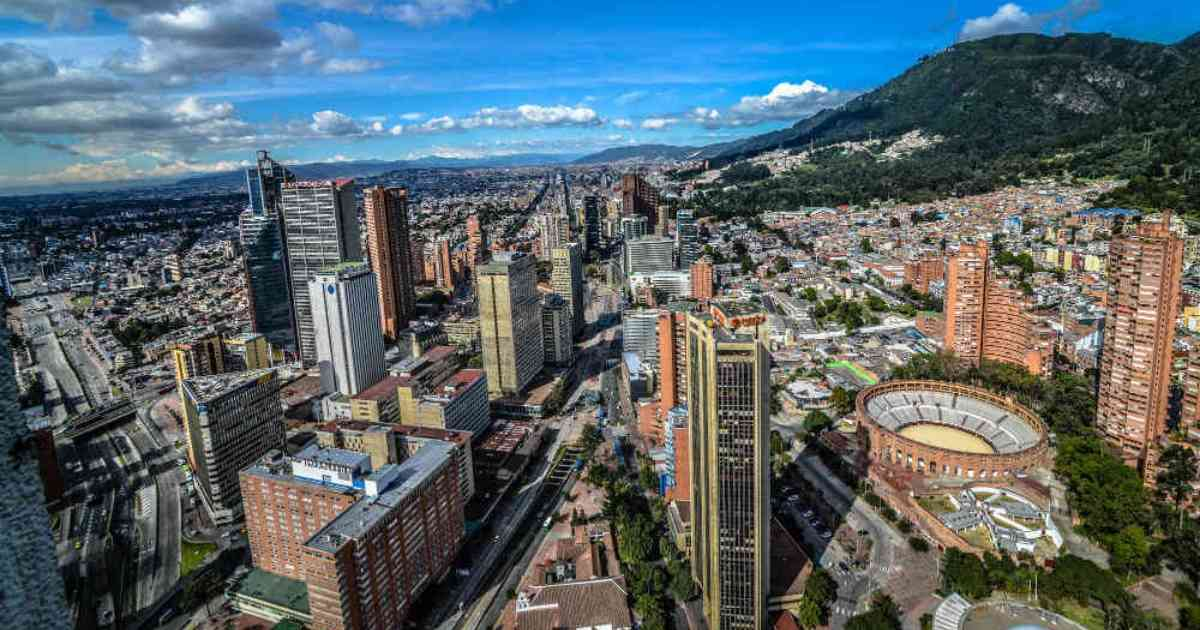

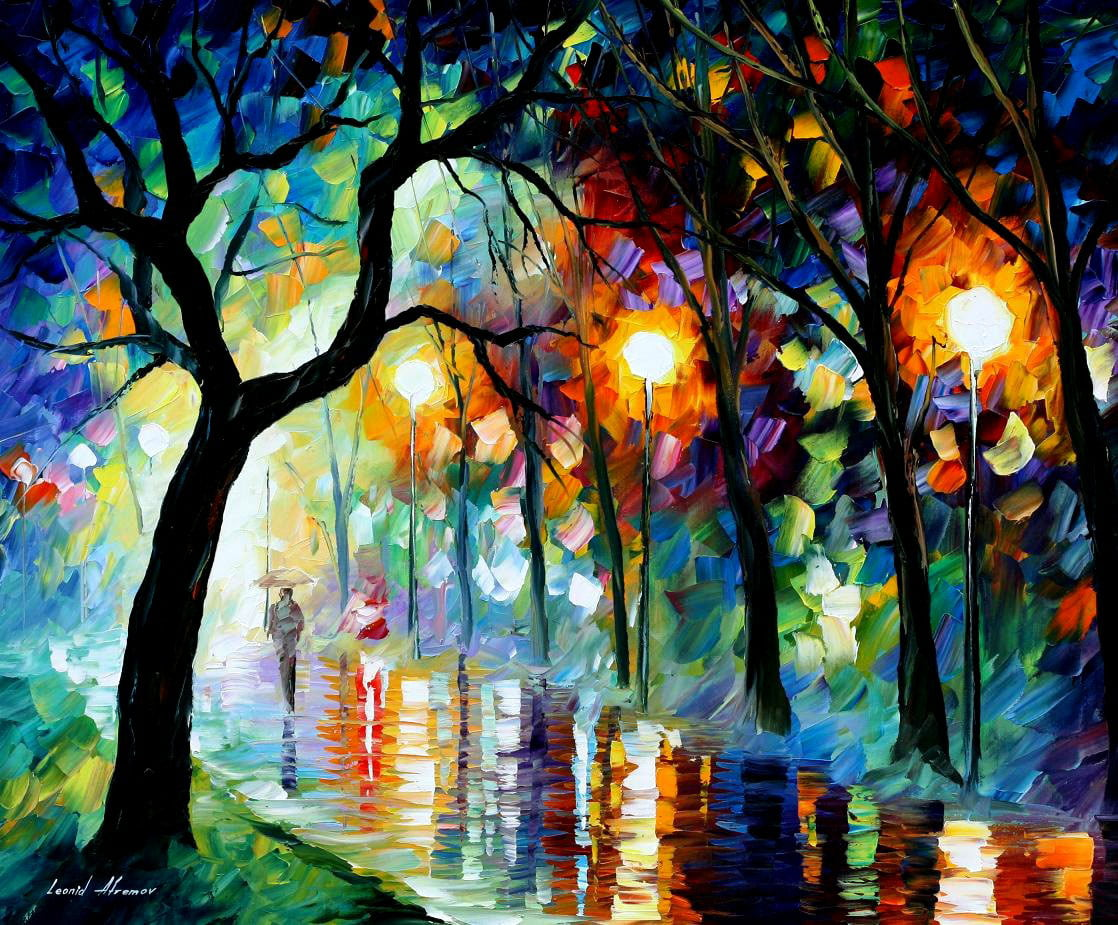

In [3]:
display(Image(path_img_contenido, width=500))
display(Image(path_img_estilo, width=500))

In [4]:
contenido = cv2.imread(path_img_contenido)
print(f'Dimensiones de imagen de contenido: {contenido.shape}')

estilo = cv2.imread(path_img_estilo)
print(f'Dimensiones de imagen de estilo: {estilo.shape}')

Dimensiones de imagen de contenido: (630, 1200, 3)
Dimensiones de imagen de estilo: (925, 1118, 3)


### 1.4 Definir funciones de apoyo para pre y post procesamiento de las imágenes

In [5]:
# Función de apoyo que prepara las imágenes para que entren al modelo VGG19
def preprocesar_imagen(image_path):
    # Cargar imagen y convertirla en un array de numpy
    img = keras.preprocessing.image.load_img(image_path, target_size=(img_filas, img_columnas))
    img = keras.preprocessing.image.img_to_array(img)
    # Se añade una dimensión al arreglo, para que quede en la forma (m, n_h, n_w, n_c)
    img = np.expand_dims(img, axis=0)
    # Preprocesamiento propio para que entre al modelo VGG19
    img = vgg19.preprocess_input(img)
    # Convertir la imagen a tensor
    return tf.convert_to_tensor(img)

# Obtiene la salida de la red neuronal (pixeles entrenados) y la adecua para
# obtener una imagen con dimensionesy valores correctos
def salida_a_imagen(x):
    # Dar dimensiones deseadas al tensor
    x = x.reshape((img_filas, img_columnas, 3))
    # Volver a sumar valores promedios por canal
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # Convertir canales de imagen de 'BGR' a 'RGB' y acotar valores
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x


---
## 2. Cargar CNN pre-entrenada 

In [6]:
# Definir un modelo VGG19 pre-entrenado con los pesos de ImageNet
# En este caso no nos interesan las últimas capas completamente conectadas
modelo = vgg19.VGG19(weights="imagenet", include_top=False)

modelo.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [7]:
# Crear un diccionario con el nombre y la salida de cada una de las capas del modelo
dict_salidas = dict([(layer.name, layer.output) for layer in modelo.layers])

# Crear un extractor de características, que devuelva los valores de activación
# para cada una de las capas del modelo, como un diccionario
extractor_crts = keras.Model(inputs=modelo.inputs, outputs=dict_salidas)

---
## 3. Cálculo de funciones de costo

### 3.1 Función de costo para el contenido $\rightarrow J_{content}(C,G)$

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$


In [8]:
def costo_contenido(a_C, a_G):
    n_h, n_w, n_c = a_G.get_shape().as_list()
    return tf.reduce_sum(tf.square(a_C - a_G)) / (4 * n_h * n_w * n_c)

### 3.2 Función de costo para el estilo $\rightarrow J_{style}(S,G)$


#### 3.2.1 Función de costo para el estilo en una sola capa $\rightarrow J_{style}^{[l]}(S,G)$

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

In [9]:
# Función auxiliar para calcular la matriz de Gram de una capa convolucional

def matriz_gram(x):
    # Se reordena el tensor (originalmente de dimensiones (n_h, n_w, n_c)) para
    # que quede con forma (n_c, n_h, n_w)
    x = tf.transpose(x, (2, 0, 1))
    # Se hace un reshape para que quede de dimensiones (n_c, n_h*n_w)
    crts = tf.reshape(x, (tf.shape(x)[0], -1))
    # Se calcula la matriz de gram como el producto matricial de la matriz de crts con su transpuesta
    gram = tf.matmul(crts, tf.transpose(crts))
    return gram

def costo_estilo_capa(a_S, a_G):
    n_h, n_w, n_c = a_G.get_shape().as_list()
    GS = matriz_gram(a_S)
    GG = matriz_gram(a_G)
    return tf.reduce_sum(tf.square(GS - GG)) / (4 * n_h**2 * (n_w * n_c)**2)
    

#### 3.2.2 Función de costo para el estilo sobre varias capas $\rightarrow J_{style}(S,G)$

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

In [10]:
def costo_estilo_total(crts, capas):
    costo_estilo = 0
    # En este caso se asigna un peso uniforme a todas las capas
    lambda_capas = 1 / len(capas)
    # Recorrido por todas las capas, para ir sumando al costo total
    for capa in capas:
        crts_capa = crts[capa]
        a_S = crts_capa[1, :, :, :]
        a_G = crts_capa[2, :, :, :]
        costo_capa = costo_estilo_capa(a_S, a_G)
        costo_estilo += lambda_capas * costo_capa
        
    return costo_estilo


### 3.3 *Total variation cost* $\rightarrow J_{total-variation}(G)$

Este componente no está en el paper original, pero se incluye para reducir un poco los componentes de alta frecuencia de la imagen generada, de manera que esta pueda ser más coherente localmente (sin cambios demasiado abruptos).

In [11]:
def variacion_total(x):
    x_deltas = x[:, :, 1:, :] - x[:, :, :-1, :]
    y_deltas = x[:, 1:, :, :] - x[:, :-1, :, :]
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))


### 3.4 Juntar todos los elementos para la función de costo total

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G) + \gamma J_{total-variation}(G)$$



In [12]:
# Lista de capas a tener en cuenta para calcular la función de costo de estilo
nombres_capas_estilo = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

# Capa para calcular costo de contenido
nombre_capa_contenido = "block4_conv3" # Originalmente "block5_conv2"

In [13]:
def calcular_costo_total(imagen_G, imagen_C, imagen_S):
    # Concatenar las tres imágenes en un solo tensor, de manera
    # que quede de dimensiones (3, n_h, n_w, n_c)
    tensor_entrada = tf.concat(
        [imagen_C, imagen_S, imagen_G], axis=0
    )
    # Obtener diccionario con activaciones en todas las capas
    # para este tensor de entrada
    crts = extractor_crts(tensor_entrada)

    # Inicializar la pérdida (o costo)
    costo_total = tf.zeros(shape=())

    # Añadir costo para el contenido
    crts_capa = crts[nombre_capa_contenido]
    a_C = crts_capa[0, :, :, :]
    a_G = crts_capa[2, :, :, :]
    costo_total = costo_total + alpha * costo_contenido(a_C, a_G)
    
    # Añadir costo para el estilo
    costo_estilo = costo_estilo_total(crts, nombres_capas_estilo)
    costo_total = costo_total + beta * costo_estilo
    
    # Añadir costo por total variation
    costo_total = costo_total + gamma * variacion_total(imagen_G)
    
    return costo_total

## 4. Compilar y correr entrenamiento

### 4.1 Función para calcular el valor del costo y los gradientes en cada iteración

In [14]:
# Se añade el decorador "tf.function" para compilar el código y, de esta forma,
# correrlo más rápido
@tf.function
def calcular_costo_y_gradientes(imagen_G, imagen_C, imagen_S):
    with tf.GradientTape() as tape:
        costo = calcular_costo_total(imagen_G, imagen_C, imagen_S)
    gradientes = tape.gradient(costo, imagen_G)
    return costo, gradientes

### 4.2 Definir el optimizador a utilizar, junto con sus parámetros

In [15]:
optimizador = keras.optimizers.Adam(1.3)

### 4.3 Correr ciclo de entrenamiento

In [16]:
# Las imágenes de contenido y estilo son constantes
imagen_C = preprocesar_imagen(path_img_contenido)
imagen_S = preprocesar_imagen(path_img_estilo)
# La imagen generada es variable
imagen_G = tf.Variable(preprocesar_imagen(path_img_contenido))

iteraciones = 500
for i in range(1, iteraciones + 1):
    # En cada iteración se calcula el costo y los gradientes
    costo, gradientes = calcular_costo_y_gradientes(imagen_G, imagen_C, imagen_S)
    # Se aplican los gradientes a la imagen generada
    optimizador.apply_gradients([(gradientes, imagen_G)])
    # Cada 20 iteraciones se imprime el costo y se guarda la imagen generada en ese momento
    if i==1 or i % 50 == 0:
        print(f"Iteración {str(i).zfill(3)}: costo={costo :.2E}")
        # Se convierte el tensor a salida y se guarda
        img = salida_a_imagen(imagen_G.numpy())
        fname = f'salida/{prefijo_salida}_iteracion_{str(i).zfill(3)}.png'
        keras.preprocessing.image.save_img(fname, img)

Iteración 001: costo=2.62E+11
Iteración 050: costo=4.93E+09
Iteración 100: costo=1.98E+09
Iteración 150: costo=1.22E+09
Iteración 200: costo=8.80E+08
Iteración 250: costo=6.91E+08
Iteración 300: costo=5.72E+08
Iteración 350: costo=4.90E+08
Iteración 400: costo=4.29E+08
Iteración 450: costo=3.83E+08
Iteración 500: costo=3.46E+08


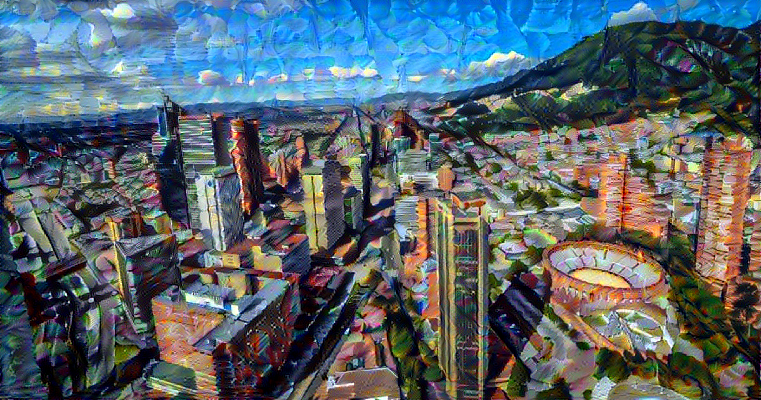

In [17]:
display(Image(f'salida/{prefijo_salida}_iteracion_{str(iteraciones).zfill(3)}.png', width=500))

---
## Ñapa: Fast Style Transfer utilizando TF-Hub

Tensorflow Hub (https://www.tensorflow.org/hub) es una biblioteca de módulos de aprendizaje automático reutilizables, que pueden ser descargados y aplicados a otros proyectos.

En esta ocasión, se utilizará un modelo pre entrenado para Fast Style Transfer, basado en el artículo **Exploring the structure of a real-time, arbitrary neural artistic stylization network** (disponible en https://arxiv.org/abs/1705.06830).

Código obtenido de: https://www.tensorflow.org/tutorials/generative/style_transfer


In [18]:
# Importar paquetes necesarios
import numpy as np
import PIL.Image
import tensorflow as tf
import tensorflow_hub as hub

# Cargar modelo pre entrenado desde tf hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

# Funciones auxiliares
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def tensor_to_image(tensor): 
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

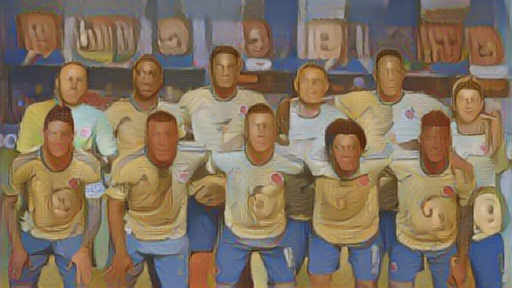

In [19]:
# Cargar imágenes
imagen_contenido = load_img('imgs/sele.jpg')
imagen_estilo = load_img('imgs/botero.jpg')

# Obtener imagen resultante
stylized_image = hub_module(tf.constant(imagen_contenido), tf.constant(imagen_estilo))[0]
tensor_to_image(stylized_image)

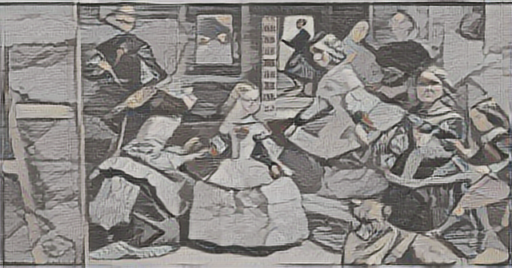

In [20]:
# Cargar imágenes
imagen_contenido = load_img('imgs/velazquez.jpg')
imagen_estilo = load_img('imgs/escher.jpg')

# Obtener imagen resultante
stylized_image = hub_module(tf.constant(imagen_contenido), tf.constant(imagen_estilo))[0]
tensor_to_image(stylized_image)